# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

![](static/privacygan_titatic_preprocessing.png)

### Dataset 01: Titanic
- source: https://www.kaggle.com/c/titanic/data
- predict the survival based on passenger information

In [14]:
df_data = pd.read_csv('data/titanic.csv')
len_prev = len(df_data)
df_data.drop(['Cabin'], axis=1, inplace=True)
df_data.dropna(inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))
df_data.head(3)

179 rows with null values dropped
712 rows of data available


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [15]:
for col in ['Name', 'Sex', 'Embarked', 'Ticket']:
    df_data[col+'_preprocessed'] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_preprocessed,Sex_preprocessed,Embarked_preprocessed,Ticket_preprocessed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,braund mr owen harris,male,s,a 5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,cumings mrs john bradley florence briggs thayer,female,c,pc 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,heikkinen miss laina,female,s,ston o2 3101282


### Visualizations

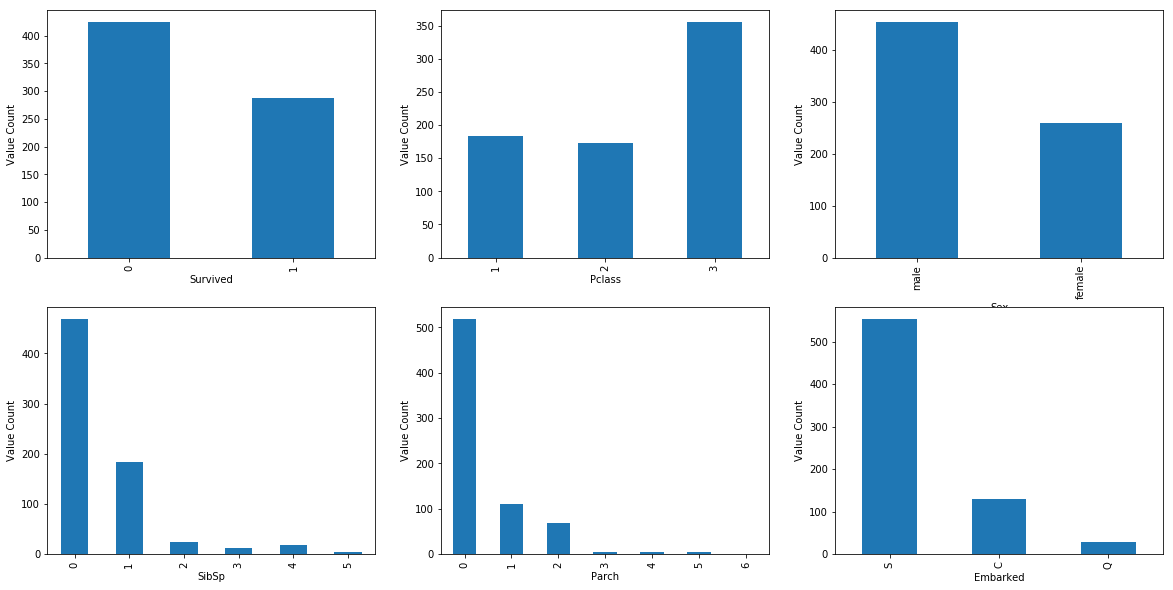

In [16]:
categorical_columns = [
    'Survived', 
    'Pclass', 
    'Sex', 
    'SibSp', 
    'Parch', 
    'Embarked'
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

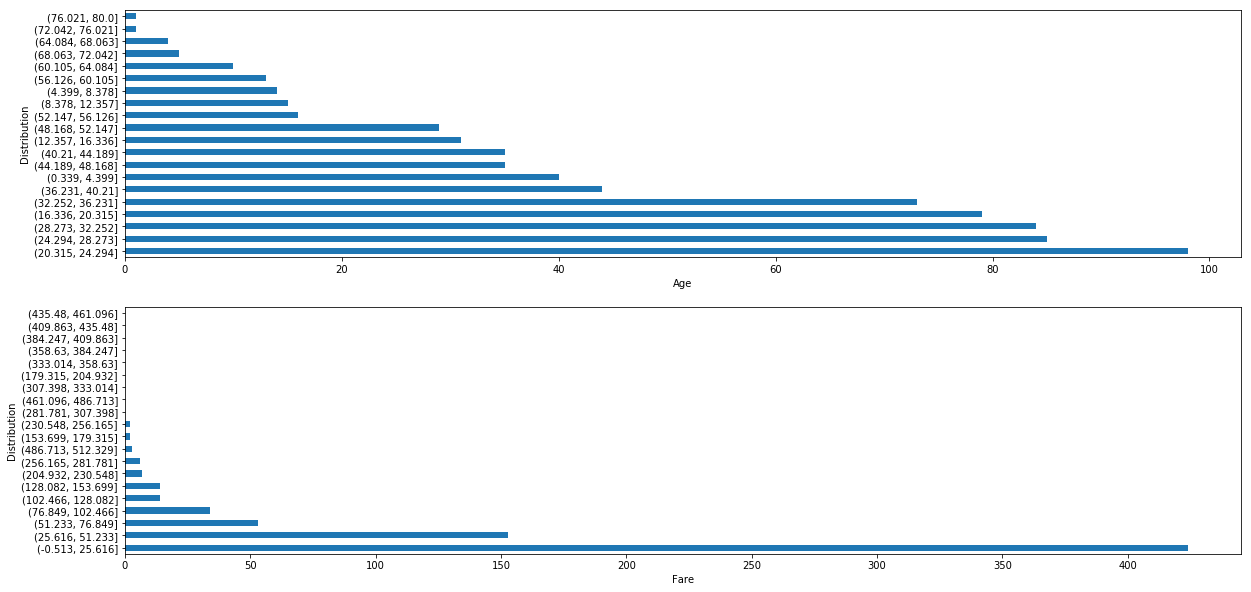

In [17]:
continuous_variables = [
    'Age', 
    'Fare'
]

num_cols = 1
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(continuous_variables)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[continuous_variables[col]].value_counts(bins=20, sort=True).plot(kind='barh')
    plt.xlabel(continuous_variables[col])
    plt.ylabel('Distribution')
plt.show()


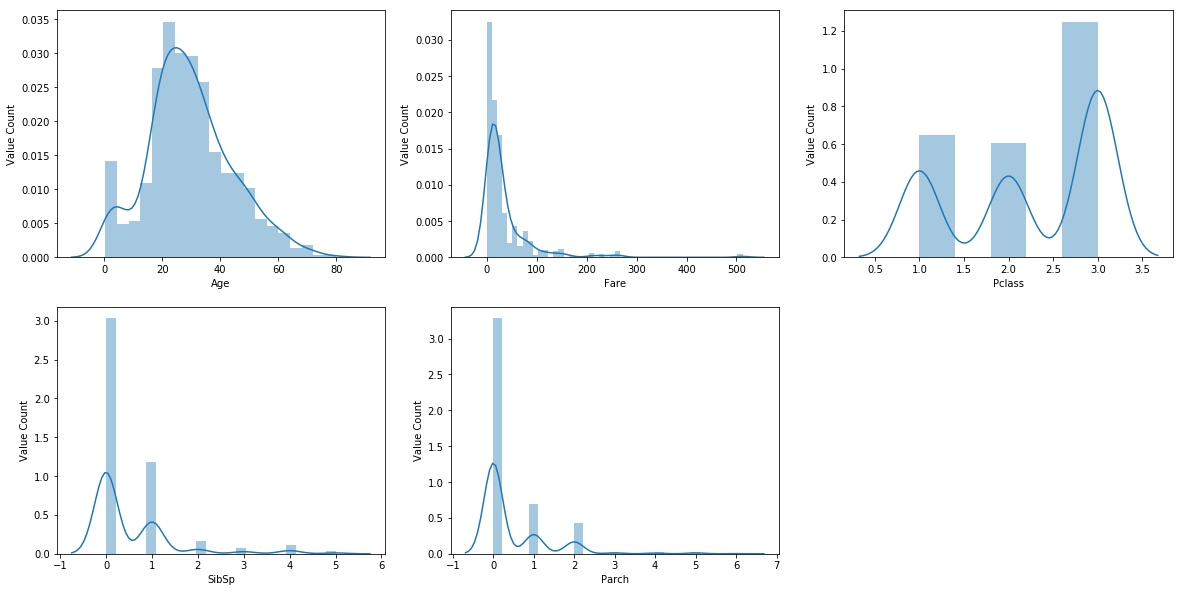

In [18]:
dist_columns = [
    'Age',
    'Fare',
    'Pclass',
    'SibSp',
    'Parch'
]

num_cols = 3
num_rows = math.ceil(len(dist_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(dist_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    sns.distplot(df_data[dist_columns[col]])
    plt.xlabel(dist_columns[col])
    plt.ylabel('Value Count')
plt.show()

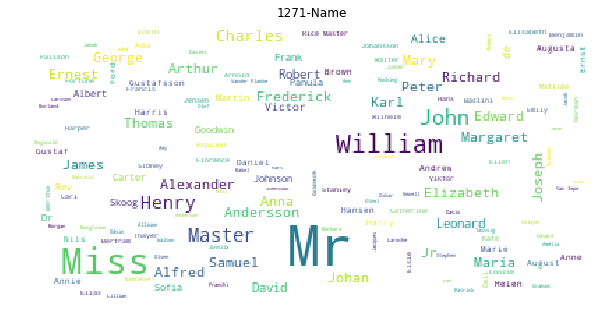

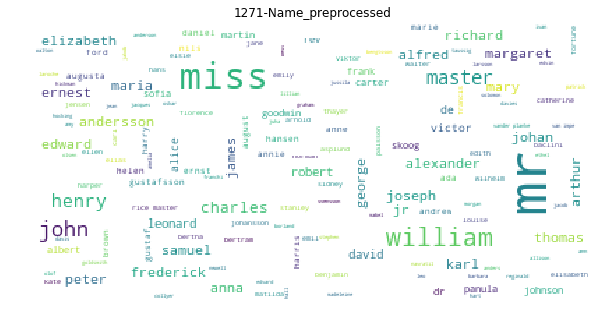

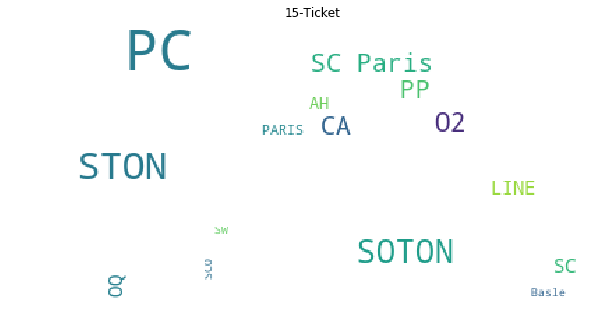

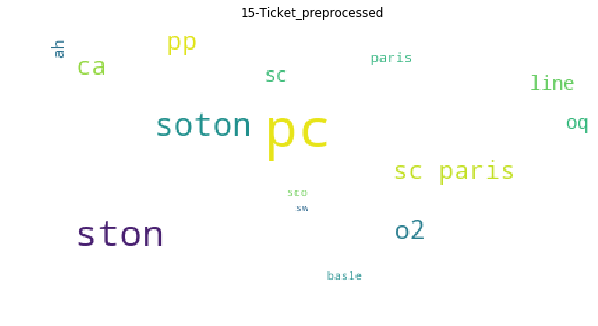

In [19]:
text_columns = ['Name', 'Name_preprocessed', 'Ticket', 'Ticket_preprocessed']

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [20]:
for col in ["Name", "Sex", "Embarked", "Ticket"]:
    df_data[col] = df_data[col+"_preprocessed"]
    df_data.drop([col+"_preprocessed"], axis=1, inplace=True)
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,braund mr owen harris,male,22.0,1,0,a 5 21171,7.2500,s
1,2,1,1,cumings mrs john bradley florence briggs thayer,female,38.0,1,0,pc 17599,71.2833,c
2,3,1,3,heikkinen miss laina,female,26.0,0,0,ston o2 3101282,7.9250,s


In [21]:
df_data = pd.get_dummies(df_data, columns=['Sex'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'])
df_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Sex_male,Pclass_1,Pclass_2,Pclass_3,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,1,0,braund mr owen harris,22.0,a 5 21171,7.2500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,1,cumings mrs john bradley florence briggs thayer,38.0,pc 17599,71.2833,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,heikkinen miss laina,26.0,ston o2 3101282,7.9250,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1,futrelle mrs jacques heath lily may peel,35.0,113803,53.1000,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,allen mr william henry,35.0,373450,8.0500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [22]:
y_ally = np.array(df_data.Sex_male.tolist())
y_advr = np.array(df_data.Survived.tolist())


df_data.drop(['Survived', 'Sex_male'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [23]:
vectorizer = CountVectorizer()
Name = vectorizer.fit_transform(df_data.Name.tolist()).toarray()
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
Ticket = vectorizer.fit_transform(df_data.Ticket.tolist()).toarray()

In [24]:
df_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df_data.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,22.0,7.2500,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [25]:
X = np.concatenate((df_data.values, Name, Ticket), axis=1)
y_ally.shape, y_advr.shape, X.shape

((712,), (712,), (712, 1324))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [26]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((640, 1324), (72, 1324), (640,), (72,), (640,), (72,))

### Checking the distribution after the split

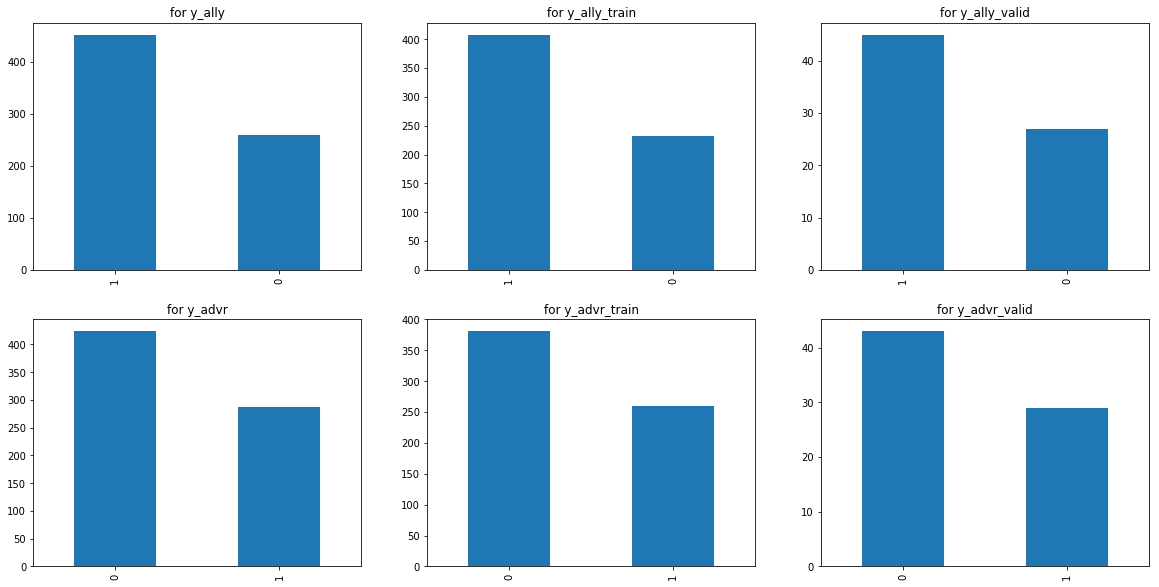

In [27]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [28]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

![](static/privacygan_titanic_experiment.png)

### Apply PCA and select components using explained variances

In [29]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [30]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9900351455272389 590


In [31]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((640, 590), (72, 590))

### Apply Auto-encoder for dimensionality reduction

![](static/privacygan_titanic_autoencoder.png)

In [32]:
import torch
import torch.utils.data as utils
import torch.nn as nn

In [33]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

X_train_torch = torch.Tensor(X_train_normalized).to(device)
X_valid_torch = torch.Tensor(X_valid_normalized).to(device)
y_ally_train_torch = torch.Tensor(y_ally_train.reshape(-1, 1)).to(device)
y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1)).to(device)
y_advr_train_torch = torch.Tensor(y_advr_train.reshape(-1, 1)).to(device)
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 1)).to(device)

DType: torch.float32
Cuda available: True
Device: cuda


In [34]:
X_train_torch.shape, X_valid_torch.shape, \
y_ally_train_torch.shape, y_ally_valid_torch.shape, \
y_advr_train_torch.shape, y_advr_valid_torch.shape

(torch.Size([640, 1324]),
 torch.Size([72, 1324]),
 torch.Size([640, 1]),
 torch.Size([72, 1]),
 torch.Size([640, 1]),
 torch.Size([72, 1]))

In [35]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [36]:
auto_encoder = AutoEncoder(input_size=X_train.shape[1],encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

In [37]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(201):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_train_torch_hat = auto_encoder(X_train_torch)
    ae_loss = criterion(X_train_torch_hat, X_train_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    if epoch%20!=0:
        continue
        
    auto_encoder.eval()
    
    X_valid_torch_hat = auto_encoder(X_valid_torch)
    ae_valid_loss = criterion(X_valid_torch_hat, X_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss
    ))
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 1.18179107 	 0.66792136
20 	 0.88807768 	 0.41938627
40 	 0.85223800 	 0.39839119
60 	 0.84401494 	 0.39044076
80 	 0.83961475 	 0.38655776
100 	 0.83779907 	 0.38471162
120 	 0.83717519 	 0.38378096
140 	 0.83690375 	 0.38323247
160 	 0.83675092 	 0.38286287
180 	 0.83665252 	 0.38258171
200 	 0.83658439 	 0.38235885


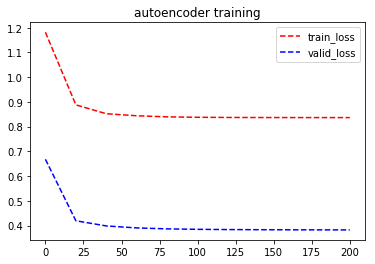

In [38]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [39]:
auto_encoder.eval()
X_train_torch_ae = auto_encoder.encoder(X_train_torch)
X_valid_torch_ae = auto_encoder.encoder(X_valid_torch)
X_train_torch_ae.shape, X_valid_torch_ae.shape

(torch.Size([640, 590]), torch.Size([72, 590]))

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

![](static/privacygan_titanic_privacygan.png)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [40]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [41]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = X_train_reduced.shape[1]
    encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
    ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1]).cuda()
    adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1]).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_optimizer = optimizer(adversary.parameters(), lr=lr_advr)

    if debug:
        print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

    g_epoch = []
    enc_train = []
    enc_valid = []
    ally_train = []
    ally_valid = []
    advr_train = []
    advr_valid = []

    for epoch in range(n_iter_gan):
        # set for training
        encoder.train()
        ally.train()
        adversary.train()

        encd_optimizer.zero_grad()
        # Forward passv
        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        # Compute Loss
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
        # Backward pass
        encd_loss.backward(retain_graph=True)
        encd_optimizer.step()

        for i in range(d_reps):
            ally_optimizer.zero_grad()
            advr_optimizer.zero_grad()

            X_train_encoding = encoder(X_train_torch)
            y_ally_train_torch_hat = ally(X_train_encoding)
            y_advr_train_torch_hat = adversary(X_train_encoding)

            ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
            advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)

            ally_loss.backward(retain_graph=True)
            advr_loss.backward(retain_graph=True)

            ally_optimizer.step()
            advr_optimizer.step()

        if epoch%20!=0 and (debug or plot):
            continue

        # set for eval
        encoder.eval()
        ally.eval()
        adversary.eval()

        X_valid_encoding = encoder(X_valid_torch)
        y_ally_valid_torch_hat = ally(X_valid_encoding)
        y_advr_valid_torch_hat = adversary(X_valid_encoding)

        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
        encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                encd_valid_loss,
                ally_loss.item(), 
                ally_valid_loss,
                advr_loss.item(),
                advr_valid_loss,
            ))

        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            enc_valid.append(encd_valid_loss.item())
            ally_train.append(ally_loss.item())
            ally_valid.append(ally_valid_loss.item())
            advr_train.append(advr_loss.item())
            advr_valid.append(advr_valid_loss.item())
    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, enc_valid, 'r--')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, ally_valid, 'b--')
        plt.plot(g_epoch, advr_train, 'g')
        plt.plot(g_epoch, advr_valid, 'g--')
        plt.legend([
            'encoder train loss', 
            'encoder valid loss',
            'ally train loss',
            'ally valid loss',
            'advr train loss',
            'advr valid loss'
        ])
        plt.title("GAN training")
        plt.show()
    
    return encoder  

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 -0.05824047 	 -0.05911317 	 0.65564156 	 0.66167474 	 0.77386791 	 0.77341640
20 	 -0.07439798 	 -0.07557958 	 0.64895320 	 0.65952420 	 0.80011237 	 0.78232652
40 	 -0.10279393 	 -0.10456684 	 0.62239850 	 0.65379310 	 0.83153218 	 0.79502881
60 	 -0.15580705 	 -0.15793815 	 0.53718871 	 0.63133770 	 0.85306501 	 0.80557948
80 	 -0.19490236 	 -0.19579616 	 0.47235519 	 0.60172451 	 0.86394751 	 0.80953860
100 	 -0.20650534 	 -0.20701335 	 0.45850977 	 0.58916390 	 0.87253648 	 0.81186706
120 	 -0.21053122 	 -0.21090919 	 0.45671159 	 0.58488858 	 0.87852997 	 0.81240511
140 	 -0.21148571 	 -0.21178406 	 0.45598584 	 0.58246917 	 0.87955397 	 0.80990559


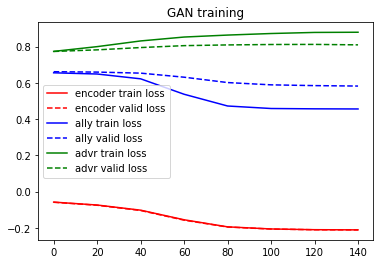

In [151]:
alpha = 0.5
lr_encd = 0.0001
lr_ally = 0.0001
lr_advr = 0.00001
n_iter_gan = 151
d_reps = 1

# alpha = 0.5
# lr_encd = 0.0001
# lr_ally = 0.0001
# lr_advr = 0.00001
# n_iter_gan = 151
# d_reps = 1


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

# Ally and Adversary Learning on Encoded Data

In [152]:
X_train_encoded = encoder(X_train_torch)
X_valid_encoded = encoder(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape

(torch.Size([640, 590]), torch.Size([72, 590]))

In [153]:
X_train_reduced.shape, X_valid_reduced.shape

((640, 590), (72, 590))

In [154]:
y_ally_train_torch.shape, y_ally_valid_torch.shape

(torch.Size([640, 1]), torch.Size([72, 1]))

In [134]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [135]:
def train_ally(lr, n_epochs, debug=True):
    network = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network.parameters(), lr=lr)    

    if debug:
        print("epoch \t ally_train \t ally_valid")

    n_epoch = []
    train = []
    valid = []
    for epoch in range(501):
        network.train()
        net_optimizer.zero_grad()

        y_ally_train_torch_hat = network(X_train_encoded)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%(int(n_epochs/10))!=0:
            continue

        # set for eval
        network.eval()
        y_ally_valid_torch_hat = network(X_valid_encoded)
        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

        if debug:
            print('{} \t {:.8f} \t {:.8f}'.format(
                epoch,  
                loss.item(),
                ally_valid_loss.item()
            ))

        n_epoch.append(epoch)
        train.append(loss.item())
        valid.append(ally_valid_loss.item())
    return n_epoch, train, valid

In [155]:
lr = 0.001
n_epochs = 501

n_epoch, gan_train_ally, gan_valid_ally = train_ally(lr, n_epochs)

epoch 	 ally_train 	 ally_valid
0 	 0.65605527 	 0.65598011
50 	 0.45623189 	 0.58068448
100 	 0.45291796 	 0.57763082
150 	 0.45210502 	 0.57671136
200 	 0.45173207 	 0.57625180
250 	 0.45152456 	 0.57598686
300 	 0.45139548 	 0.57582283
350 	 0.45130882 	 0.57571775
400 	 0.45124751 	 0.57564956
450 	 0.45120221 	 0.57560599
500 	 0.45116767 	 0.57557946


In [137]:
def train_advr(lr, n_epochs, debug=True):
    network_advr = Network(X_train_reduced.shape[1], 128, 1).cuda()
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

    if debug:
        print("epoch \t advr_train \t advr_valid")

    train_a = []
    valid_a = []

    for epoch in range(n_epochs):
        network_advr.train()
        net_optimizer.zero_grad()

        y_advr_train_torch_hat = network_advr(X_train_encoded)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%(int(n_epochs/10))!=0:
            continue

        # set for eval
        network_advr.eval()
        y_advr_valid_torch_hat = network_advr(X_valid_encoded)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

        if debug:
            print('{} \t {:.8f} \t {:.8f}'.format(
                epoch,  
                loss.item(),
                advr_valid_loss.item()
            ))
        train_a.append(loss.item())
        valid_a.append(advr_valid_loss.item())
    return train_a, valid_a

In [156]:
lr = 0.0001
n_epochs = 501

gan_train_advr, gan_valid_advr = train_advr(lr, n_epochs)

epoch 	 advr_train 	 advr_valid
0 	 0.78537893 	 0.78309679
50 	 0.66343766 	 0.72092825
100 	 0.62470025 	 0.70908004
150 	 0.60552162 	 0.70428193
200 	 0.59210598 	 0.70305043
250 	 0.58160931 	 0.70364314
300 	 0.57349008 	 0.70484620
350 	 0.56734961 	 0.70622259
400 	 0.56272709 	 0.70764863
450 	 0.55921596 	 0.70906526
500 	 0.55650795 	 0.71043986


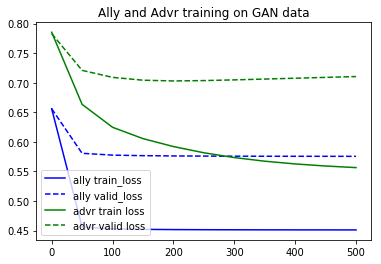

In [157]:
plt.plot(n_epoch, gan_train_ally, 'b')
plt.plot(n_epoch, gan_valid_ally, 'b--')
plt.plot(n_epoch, gan_train_advr, 'g')
plt.plot(n_epoch, gan_valid_advr, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on GAN data")
plt.show()

# Variations over Alpha

In [71]:
alphas = [0, 0.25, 0.5, 0.75, 1]

Comparison


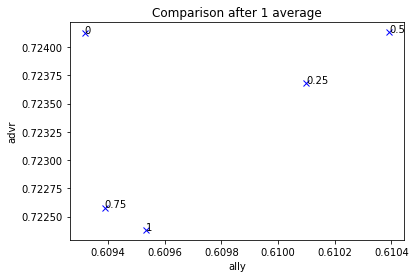

Comparison


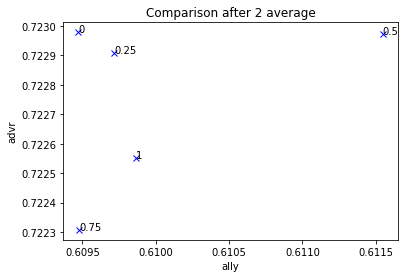

Comparison


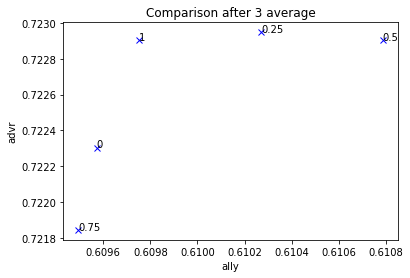

Comparison


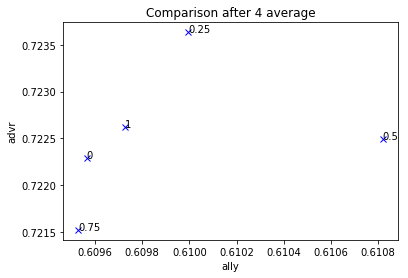

Comparison


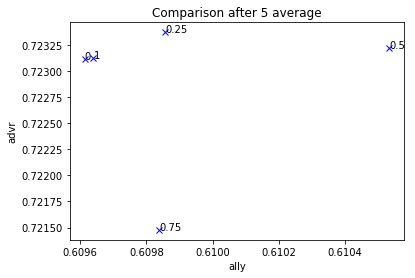

Comparison


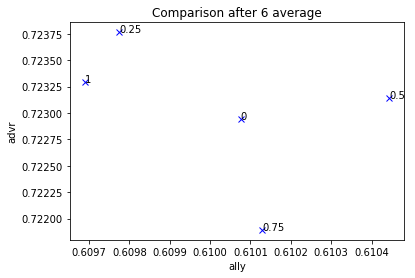

Comparison


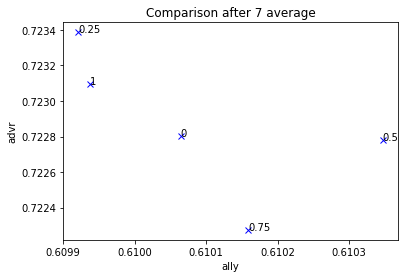

Comparison


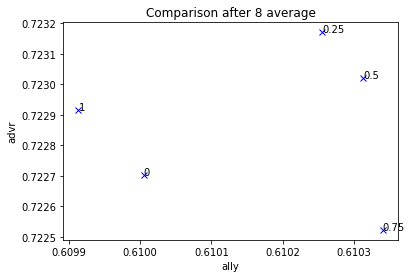

Comparison


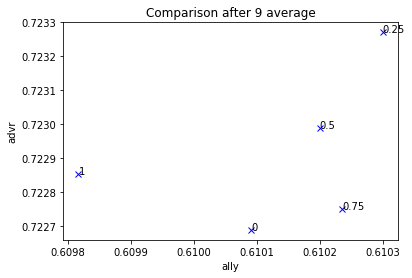

Comparison


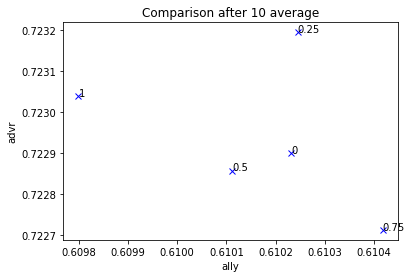

In [74]:
gan_ally_over_alpha = [0, 0, 0, 0, 0]
gan_advr_over_alpha = [0, 0, 0, 0, 0]
average_over = 10
for i in range(average_over):
    for idx, alpha in enumerate(alphas):
#         print("="*80)
#         print(alpha)
#         print("="*80)
        train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=False, debug=False)
        n_epoch, gan_train_ally, gan_valid_ally = train_ally(lr, n_epochs, debug=False)
        gan_train_advr, gan_valid_advr = train_advr(lr, n_epochs, False)
        gan_ally_over_alpha[idx] = i * gan_ally_over_alpha[idx] + gan_valid_ally[-1]
        gan_advr_over_alpha[idx] = i * gan_advr_over_alpha[idx] + gan_valid_advr[-1]
#         plt.plot(n_epoch, gan_train_ally, 'b')
#         plt.plot(n_epoch, gan_valid_ally, 'b--')
#         plt.plot(n_epoch, gan_train_advr, 'g')
#         plt.plot(n_epoch, gan_valid_advr, 'g--')
#         plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
#         plt.title("Ally and Advr training on GAN data")
#         plt.show()
    gan_ally_over_alpha = [_/(i+1) for _ in gan_ally_over_alpha]
    gan_advr_over_alpha = [_/(i+1) for _ in gan_advr_over_alpha]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    print("="*80)
    print("Comparison")
    print("="*80)
    plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
    plt.xlabel('ally')
    plt.ylabel('advr')
    plt.title('Comparison after {} average'.format(i+1))
    for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
        ax.annotate('%s' % label, xy=xy, textcoords='data')
    plt.show()

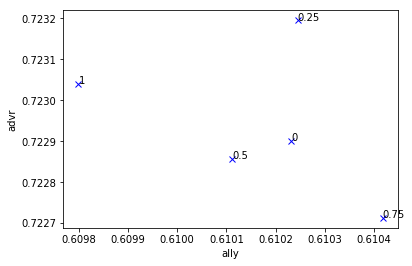

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
plt.xlabel('ally')
plt.ylabel('advr')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

# Ally and Adversary Learning on DP Data

In [76]:
def laplaceMechanism(x, epsilon):
    x +=  torch.Tensor(np.random.laplace(0, 1.0/epsilon, x.shape)).cuda()
    return x

In [77]:
epsilon = 0.1

In [90]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

lr = 0.00001

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

dp_ally_train = []
dp_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    
    y_ally_train_torch_hat = network_ally_pca(X_train_iter)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    dp_ally_train.append(loss.item())
    dp_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.65560144 	 0.66129422
50 	 0.65335077 	 0.66127759
100 	 0.65156192 	 0.66129178
150 	 0.64935237 	 0.66131073
200 	 0.65008253 	 0.66133958
250 	 0.64866871 	 0.66134495
300 	 0.64695686 	 0.66135377
350 	 0.64690179 	 0.66138685
400 	 0.64464855 	 0.66143662
450 	 0.64445144 	 0.66150111
500 	 0.64338714 	 0.66156894


In [88]:
lr = 0.0001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

dp_advr_train = []
dp_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
    y_advr_train_torch_hat = network_advr_pca(X_train_iter)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    dp_advr_train.append(loss.item())
    dp_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.78196728 	 0.78192967
50 	 0.74095440 	 0.76434928
100 	 0.71589750 	 0.75038218
150 	 0.69954437 	 0.74045163
200 	 0.68847048 	 0.73374838
250 	 0.67983341 	 0.72936463
300 	 0.67194813 	 0.72681999
350 	 0.66441154 	 0.72559190
400 	 0.65760106 	 0.72542202
450 	 0.64915562 	 0.72597420
500 	 0.64113468 	 0.72699767


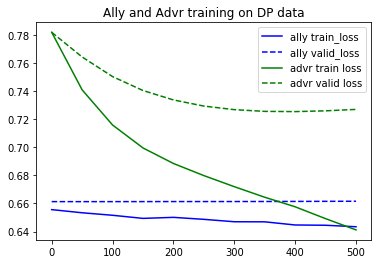

In [91]:
plt.plot(n_epoch, dp_ally_train, 'b')
plt.plot(n_epoch, dp_ally_valid, 'b--')
plt.plot(n_epoch, dp_advr_train, 'g')
plt.plot(n_epoch, dp_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on DP data")
plt.show()

In [92]:
epsilons = [1, 26, 51, 71, 101,]

1 0.4522217810153961 0.624424397945404
1 0.5408331751823425 0.7563066482543945


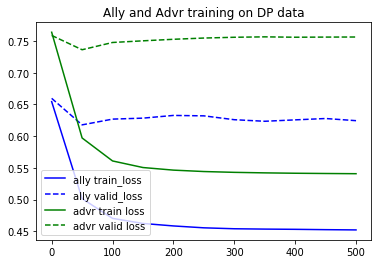

26 0.4578703045845032 0.5154730081558228
26 0.5461152195930481 0.6956834197044373


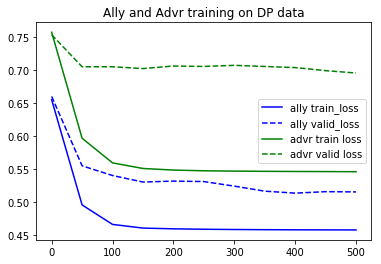

51 0.4587697982788086 0.5193855166435242
51 0.5467714667320251 0.6892679333686829


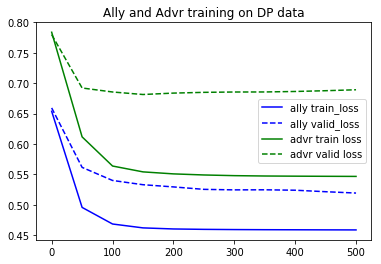

71 0.4577732980251312 0.5001555681228638
71 0.5448141694068909 0.6917551159858704


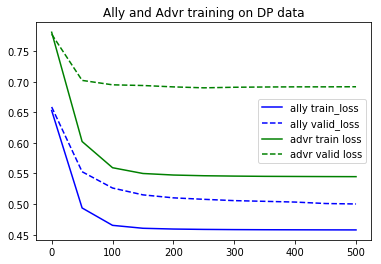

101 0.46063730120658875 0.5207815766334534
101 0.545287549495697 0.6975730657577515


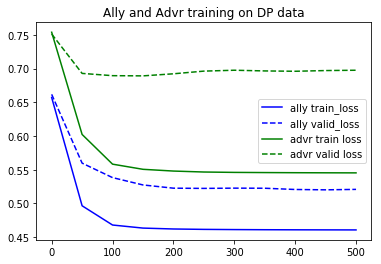

In [93]:
ally_dp_over_epsilons = []
advr_dp_over_epsilons = []
for epsilon in epsilons:
    X_train_pca_torch = torch.Tensor(X_train_reduced)
    X_valid_pca_torch = torch.Tensor(X_valid_reduced)

    lr = 0.001

    network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

    dp_ally_train = []
    dp_ally_valid = []

    X_train_pca_torch = X_train_pca_torch.to(device)
    X_valid_pca_torch = X_valid_pca_torch.to(device)
    y_ally_train_torch = y_ally_train_torch.to(device)
    y_ally_valid_torch = y_ally_valid_torch.to(device)

    for epoch in range(501):
        network_ally_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)

        y_ally_train_torch_hat = network_ally_pca(X_train_iter)
        loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_ally_pca.eval()
        y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
        ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)

        dp_ally_train.append(loss.item())
        dp_ally_valid.append(ally_valid_loss)

    ally_dp_over_epsilons.append(ally_valid_loss.item())
    print(epsilon, loss.item(), ally_valid_loss.item())

    lr = 0.001

    network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam
    net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

    y_advr_train_torch = y_advr_train_torch.to(device)
    y_advr_valid_torch = y_advr_valid_torch.to(device)

    dp_advr_train = []
    dp_advr_valid = []

    for epoch in range(501):
        network_advr_pca.train()
        net_optimizer.zero_grad()

        X_train_iter = laplaceMechanism(X_train_pca_torch, epsilon)
        y_advr_train_torch_hat = network_advr_pca(X_train_iter)
        loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        loss.backward(retain_graph = True)
        net_optimizer.step()

        if (epoch)%50!=0:
            continue

        # set for eval
        network_advr_pca.eval()
        y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
        advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)

        dp_advr_train.append(loss.item())
        dp_advr_valid.append(advr_valid_loss)

    print(epsilon, loss.item(), advr_valid_loss.item())
    advr_dp_over_epsilons.append(advr_valid_loss.item())
    
    plt.plot(n_epoch, dp_ally_train, 'b')
    plt.plot(n_epoch, dp_ally_valid, 'b--')
    plt.plot(n_epoch, dp_advr_train, 'g')
    plt.plot(n_epoch, dp_advr_valid, 'g--')
    plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
    plt.title("Ally and Advr training on DP data")
    plt.show()

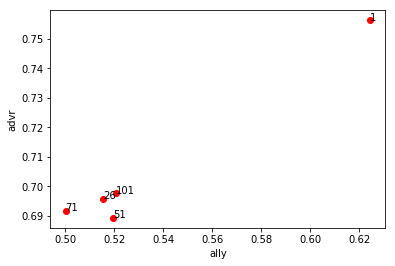

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.xlabel('ally')
plt.ylabel('advr')

for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')

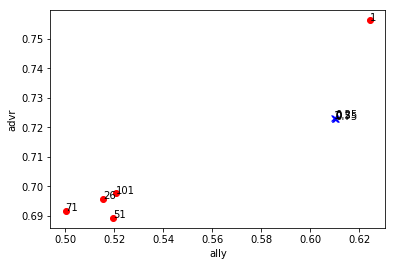

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()

# Ally and Adversary Learning on PCA Data

In [96]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

In [97]:
lr = 0.01

network_ally_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

pca_ally_train = []
pca_ally_valid = []

X_train_pca_torch = X_train_pca_torch.to(device)
X_valid_pca_torch = X_valid_pca_torch.to(device)
y_ally_train_torch = y_ally_train_torch.to(device)
y_ally_valid_torch = y_ally_valid_torch.to(device)

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    pca_ally_train.append(loss.item())
    pca_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.65721202 	 0.64478058
50 	 0.46272644 	 0.50400704
100 	 0.46189412 	 0.50243551
150 	 0.46187815 	 0.50136572
200 	 0.46186948 	 0.50052315
250 	 0.46186447 	 0.49987805
300 	 0.46186104 	 0.49936354
350 	 0.46185857 	 0.49895012
400 	 0.46185684 	 0.49861071
450 	 0.46185476 	 0.49833837
500 	 0.46181020 	 0.49830490


In [98]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

y_advr_train_torch = y_advr_train_torch.to(device)
y_advr_valid_torch = y_advr_valid_torch.to(device)

pca_advr_train = []
pca_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    pca_advr_train.append(loss.item())
    pca_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.74235600 	 0.73978752
50 	 0.60026366 	 0.69383758
100 	 0.55890352 	 0.68709737
150 	 0.55104816 	 0.68460226
200 	 0.54907143 	 0.68444210
250 	 0.54673970 	 0.68676269
300 	 0.54602778 	 0.68763649
350 	 0.54524547 	 0.68893272
400 	 0.54499954 	 0.68986356
450 	 0.54483795 	 0.69054085
500 	 0.54472357 	 0.69111031


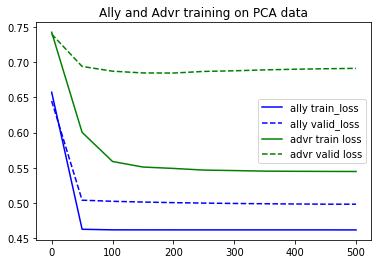

In [99]:
plt.plot(n_epoch, pca_ally_train, 'b')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_train, 'g')
plt.plot(n_epoch, pca_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on PCA data")
plt.show()

# Ally and Adversary Training on Auto-encoded data

In [100]:
lr = 0.001

network_ally_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

ae_ally_train=[]
ae_ally_valid = []

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    ae_ally_train.append(loss.item())
    ae_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.65702230 	 0.65495431
50 	 0.45872337 	 0.54980236
100 	 0.45328090 	 0.54565698
150 	 0.45224974 	 0.54441190
200 	 0.45180902 	 0.54375064
250 	 0.45157185 	 0.54331523
300 	 0.45142728 	 0.54300147
350 	 0.45133162 	 0.54276109
400 	 0.45126459 	 0.54256904
450 	 0.45121548 	 0.54241121
500 	 0.45117816 	 0.54227853


In [101]:
lr = 0.001

network_advr_ae = Network(X_train_reduced.shape[1], 128, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

ae_advr_train = []
ae_advr_valid = []

for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    ae_advr_train.append(loss.item())
    ae_advr_valid.append(advr_valid_loss)

epoch 	 advr_train 	 advr_valid
0 	 0.76470912 	 0.74295682
50 	 0.69431311 	 0.69461042
100 	 0.69305605 	 0.69382328
150 	 0.63270134 	 0.68671799
200 	 0.57329744 	 0.68072563
250 	 0.56357443 	 0.67842036
300 	 0.55976892 	 0.67967647
350 	 0.55828810 	 0.68003994
400 	 0.55769908 	 0.68193817
450 	 0.55742335 	 0.68236530
500 	 0.55724782 	 0.68282270


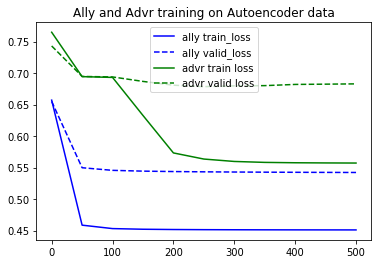

In [102]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | 0.54596204 | **0.63508838** | 0.45774460 | 0.47422782 |
| A-Enc | 0.69294691 | 0.69324082 | 0.45286497 | 0.50768989 |
| P-GAN | 0.53968185 | 0.69574529 | 0.45563743 | **0.59513420** |

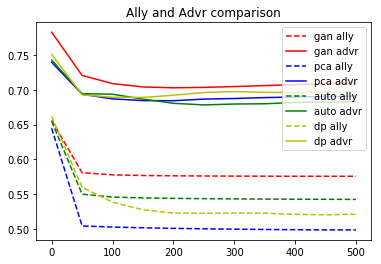

In [158]:
plt.plot(n_epoch, gan_valid_ally, 'r--')
plt.plot(n_epoch, gan_valid_advr, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.plot(n_epoch, dp_ally_valid, 'y--')
plt.plot(n_epoch, dp_advr_valid, 'y')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr', 'dp ally', 'dp advr'])
plt.title("Ally and Advr comparison")
plt.show()

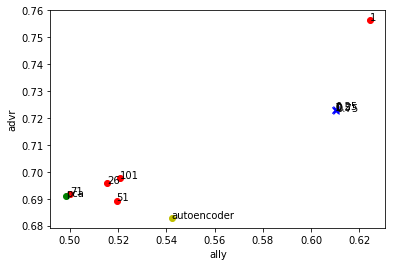

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ally_dp_over_epsilons, advr_dp_over_epsilons, 'ro')
plt.plot(gan_ally_over_alpha, gan_advr_over_alpha, 'bx')
for label, xy in zip(epsilons, zip(ally_dp_over_epsilons, advr_dp_over_epsilons)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
for label, xy in zip(alphas, zip(gan_ally_over_alpha, gan_advr_over_alpha)):               
    ax.annotate('%s' % label, xy=xy, textcoords='data')
plt.plot([pca_ally_valid[-1]], [pca_advr_valid[-1]], 'go')
ax.annotate('%s' % 'pca', xy=(pca_ally_valid[-1], pca_advr_valid[-1]), textcoords='data')
plt.plot([ae_ally_valid[-1]], [ae_advr_valid[-1]], 'yo')
ax.annotate('%s' % 'autoencoder', xy=(ae_ally_valid[-1], ae_advr_valid[-1]), textcoords='data')
plt.xlabel('ally')
plt.ylabel('advr')
plt.show()